<a href="https://colab.research.google.com/github/ShriSathiya/CapstoneProject/blob/main/Wheel_Vigiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>- Wheel Vigiler -</center></h1>

![sieve shaker](../data-warehouse/logo.png)

    -A Deep Learning based car identification model.

## Project Contributor :
        
            1. Piyali
            2. Satish
            3. Sathiya
            4. Shreejit
            5. Shreyansh

## Project Mentor : Saravanan

## Domain : Automotive | Surveilance

## Project Objective : Design a DL based car Identification model

## Project Context :

In computer vision, object recognition is a technology which able to ease human activity to identify object obtained from digital image. Here being identified object is car, and the recognition method is using arrangement of 2 dimensional basic geometric shape that correspond to the simplification of car image. Vehicle detection and identification in urban scenarios has many civilian, security and surveillance application. The detection of vehicles in a traffic scene can address wide range of traffic problems.

## Problem Summary :

To Find The Best approach to identify the vehicle in the static images. Here an attempt has been made to reduce the search time to find the possible vehicle candidates thereby reducing the computation time without a full search.

## Data Summarry :

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

+ Train Images     : Consists of real images of cars as per the make and year of the car.
+ Test Images      : Consists of real images of cars as per the make and year of the car.
+ Train Annotation : Consists of bounding box region for training images.
+ Test Annotation  : Consists of bounding box region for testing images.
+ Classes          : Consists of Name of Cars

# Milestone - 1

In [ ]:
# Import Block

In [5]:
import os
import torch
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms # TODO
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

In [116]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
import albumentations as A
import pprint
from optparse import OptionParser
import pickle
import math
import copy
import tensorflow as tf

import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from tensorflow.keras.utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.metrics import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers



from sklearn.metrics import average_precision_score

from keras import backend as K

from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed

from keras.utils import layer_utils
from keras.utils.data_utils import get_file


from keras.models import Model
from keras.utils import generic_utils

from keras import initializers, regularizers

In [6]:
warnings.filterwarnings("ignore")

In [7]:
# Static Constant Block

In [25]:
datadir_warehouse         = '/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/'
datadir_root              = datadir_warehouse + 'car_data/'
datadir_image_train       = datadir_root + 'train/'
datadir_image_test        = datadir_root + 'test/'
datafile_annotation_train = datadir_root + "anno_train.csv"
datafile_annotation_test  = datadir_root + "anno_test.csv"
datafile_classes          = datadir_root + "names.csv"
plot_height               = 9
plot_width                = 15

# :- EDA & Visualization

## STEP 1 : Import the data

In [15]:
# Define a Method to Load the Image, Annotation and Classes Data for Training and Testing Set

In [26]:
def load_data():
    global dataset_images_train
    global dataset_images_test
    global dataset_annotation_train
    global dataset_annotation_train
    global dataset_annotation_test
    global dataset_classes

    dataset_images_train     = ImageFolder(datadir_image_train)
    dataset_images_test      = ImageFolder(datadir_image_test)
    dataset_annotation_train = pd.read_csv(datafile_annotation_train, 
                                           names=["file_name", "x1", "y1", "x2", "y2", "class_index"])
    dataset_annotation_test  = pd.read_csv(datafile_annotation_test,
                                           names=["file_name", "x1", "y1", "x2", "y2", "class_index"])
    dataset_classes           = pd.read_csv(datafile_classes, names=["classes"])

In [28]:
load_data()

In [29]:
def get_image_metadata(dataset_images):
    image_data = pd.DataFrame(columns=['image_path', 'class_index', 'file_name'])
    image_metadata = pd.DataFrame(columns=['height', 'width', 'resolution', 'chennel'])
    for x in dataset_images.imgs:
        file_name = x[0][-9::1]
        image_loader = dataset_images.loader(x[0])
        size = image_loader.size
        temp = {'image_path' : x[0], "class_index": x[1], "file_name": file_name}
        image_data = image_data.append(temp, ignore_index=True)
        temp = {'height': size[0], 'width':size[1], 'resolution':size[0] * size[1], 'chennel':image_loader.mode}
        image_metadata = image_metadata.append(temp, ignore_index=True)
    return image_data, image_metadata

In [30]:
global image_data_train, image_metadata_train
image_data_train, image_metadata_train = get_image_metadata(dataset_images_train)

global image_data_test, image_metadata_test
image_data_test, image_metadata_test = get_image_metadata(dataset_images_test)

In [31]:
dataset_images_train.classes[0:5]

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008']

In [32]:
dataset_images_train.imgs[0:5]

[('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/AM General Hummer SUV 2000/00163.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/AM General Hummer SUV 2000/00462.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/AM General Hummer SUV 2000/00522.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/AM General Hummer SUV 2000/00707.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/AM General Hummer SUV 2000/00773.jpg',
  0)]

In [33]:
dataset_images_test.classes[0:5]

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008']

In [34]:
dataset_images_test.imgs[0:5]

[('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000/00076.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000/00457.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000/00684.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000/01117.jpg',
  0),
 ('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000/01167.jpg',
  0)]

In [35]:
dataset_annotation_train.sample(5)

file_name   x1     y1      x2      y2 class_index
281   00281.jpg  214  240.0   387.0   342.0         151
2098  02098.jpg   15   17.0   636.0   440.0          58
2965  02965.jpg   58    1.0  1561.0  1195.0         133
5757  05757.jpg   14   56.0   442.0   292.0         124
144   00144.jpg   66   59.0   283.0   202.0          71

In [36]:
dataset_annotation_test.sample(5)

file_name  x1     y1     x2     y2 class_index
6242  06242.jpg  22   73.0  253.0  170.0          38
4434  04434.jpg  26   41.0  236.0  158.0         125
5910  05910.jpg   2   52.0  253.0  167.0          80
6824  06824.jpg  16  130.0  609.0  394.0          80
6180  06180.jpg   4   81.0  500.0  302.0         166

In [37]:
dataset_classes.sample(5)

classes
111                   Ford Ranger SuperCab 2011
74   Chevrolet Silverado 1500 Extended Cab 2012
150             Lamborghini Reventon Coupe 2008
14                          Audi TTS Coupe 2012
65            Chevrolet Avalanche Crew Cab 2012

In [38]:
# Define a method to Display the images from the Train and Test Set

In [39]:
def show_image(dataset, index):
    img, classs = dataset[index]
    print("\nImage class Index : ", classs)
    print("Image class       : ", dataset.classes[classs])
    print("Image Size        :", img.size)
    display(img);


Image class Index :  2
Image class       :  Acura RL Sedan 2012
Image Size        : (2100, 1575)


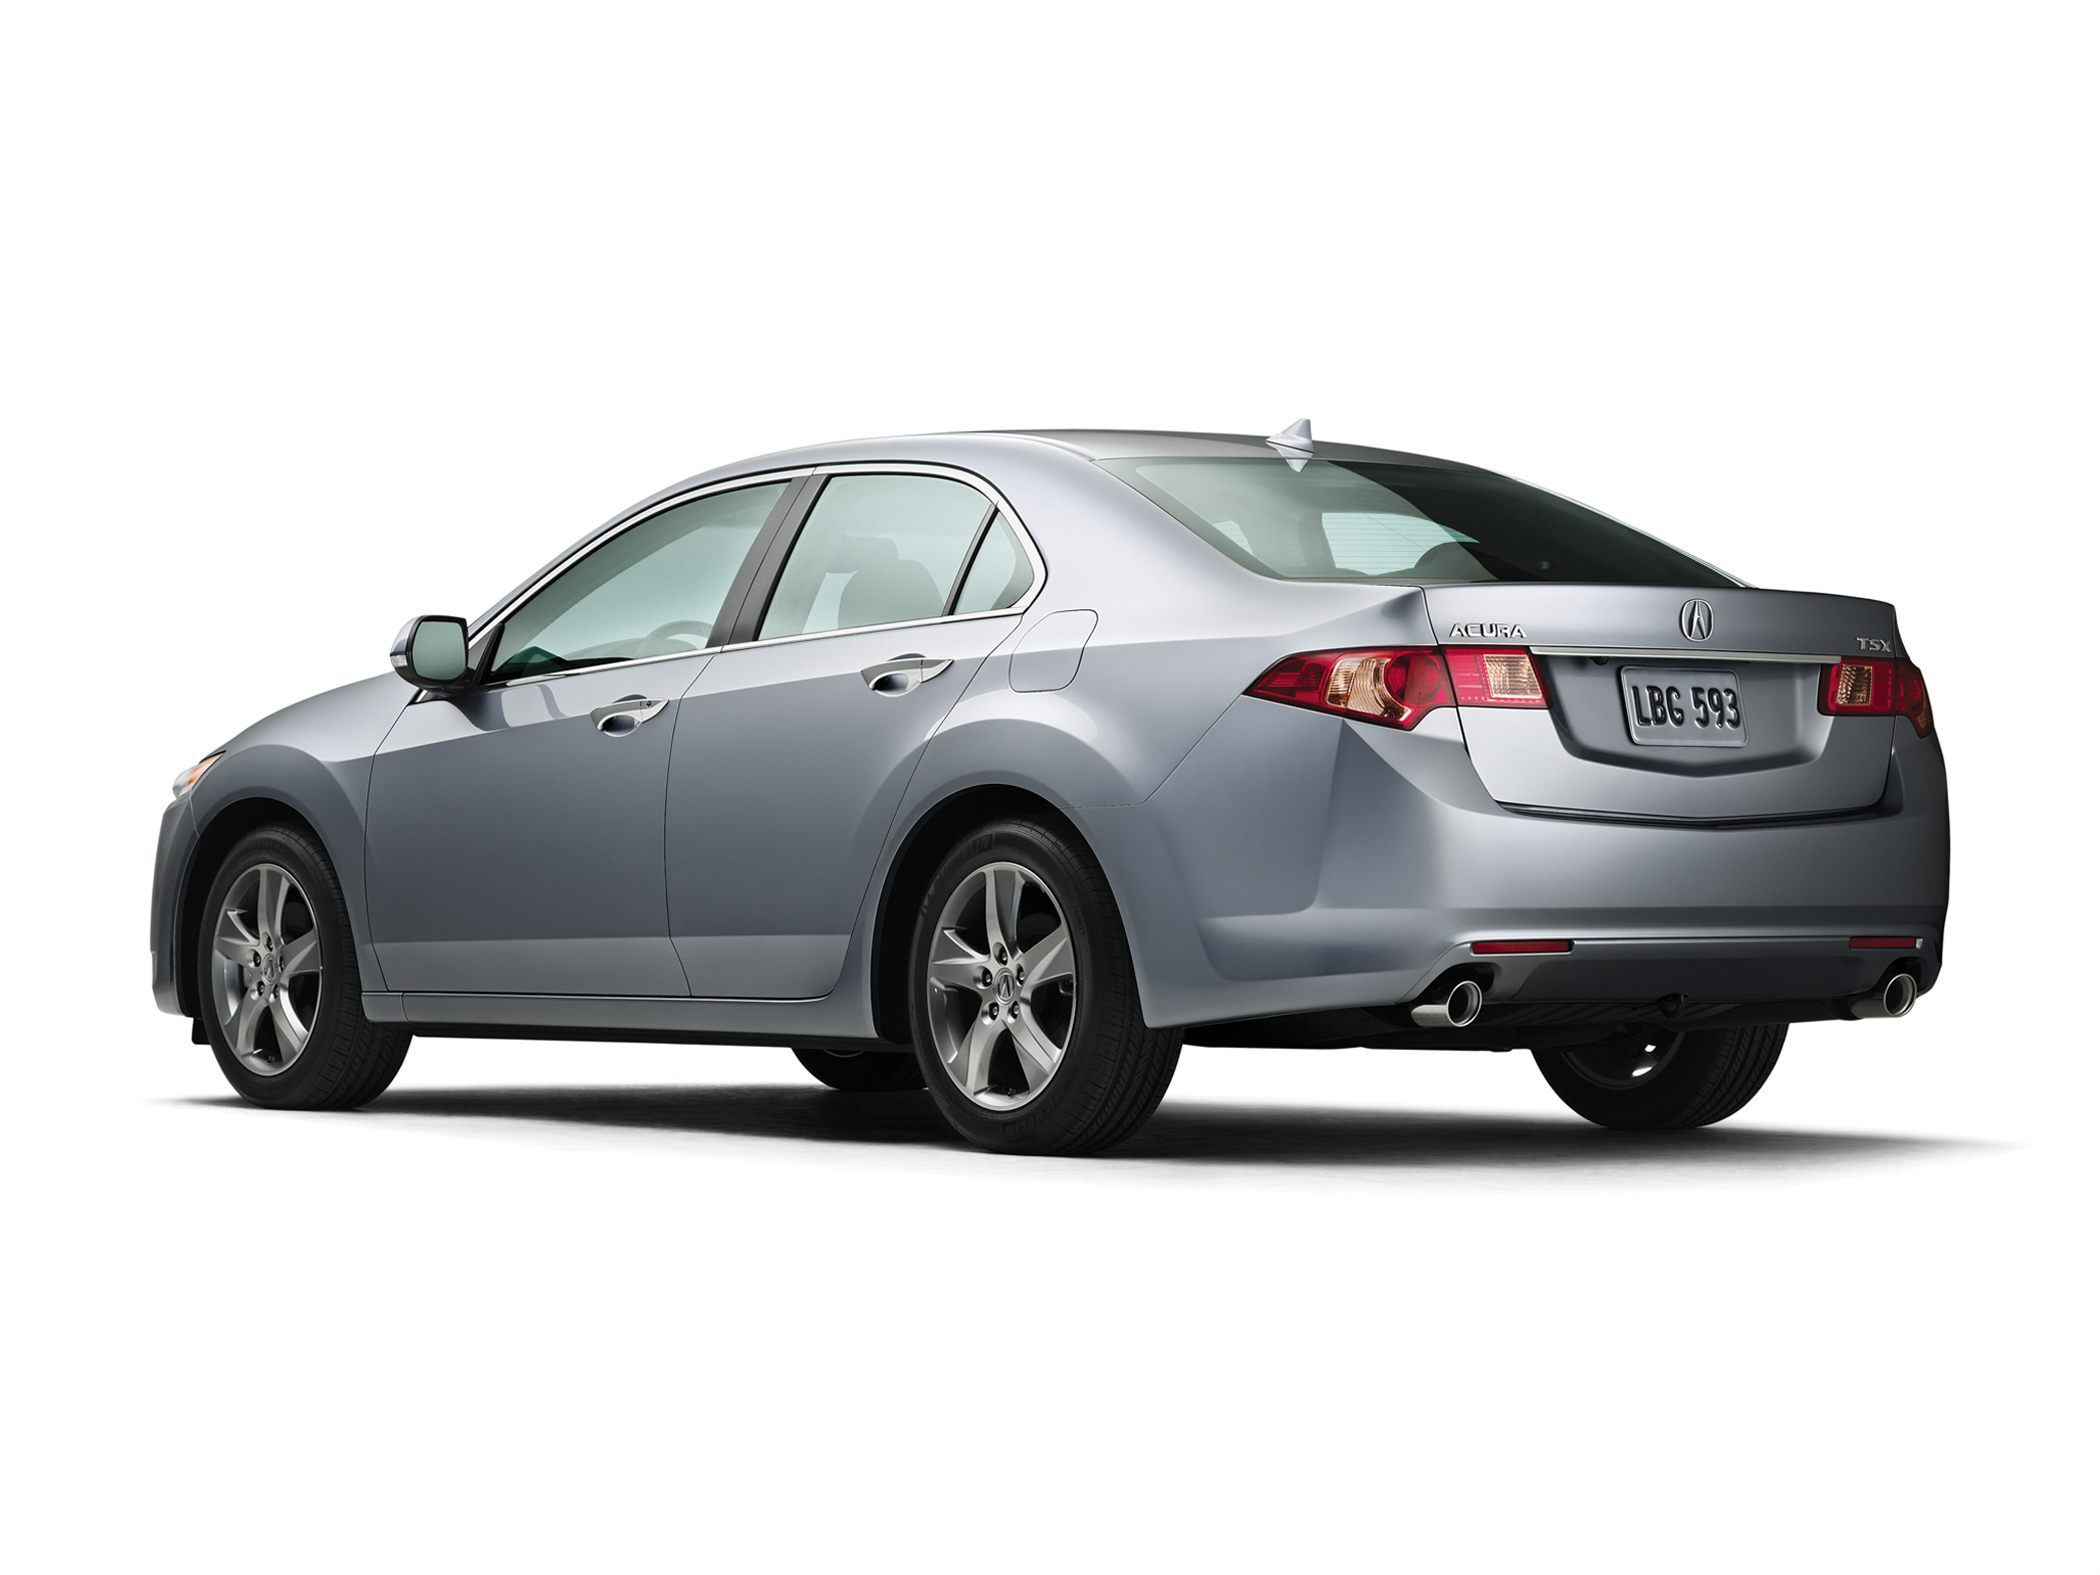


Image class Index :  4
Image class       :  Acura TL Type-S 2008
Image Size        : (1024, 768)


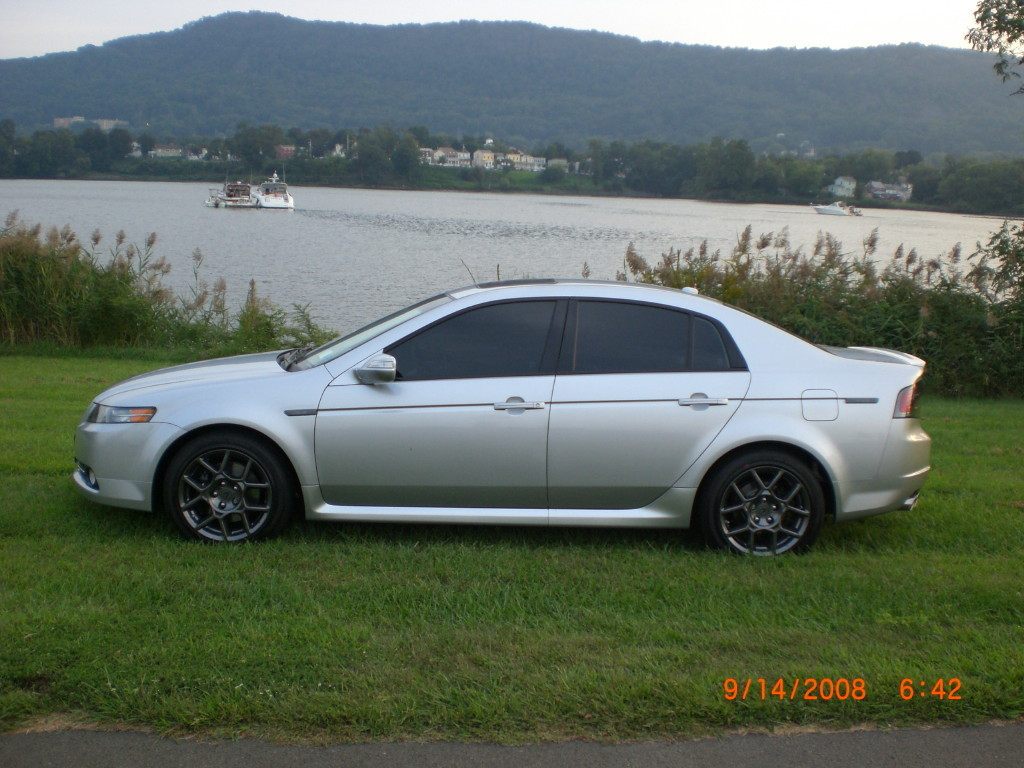


Image class Index :  8
Image class       :  Aston Martin V8 Vantage Coupe 2012
Image Size        : (750, 500)


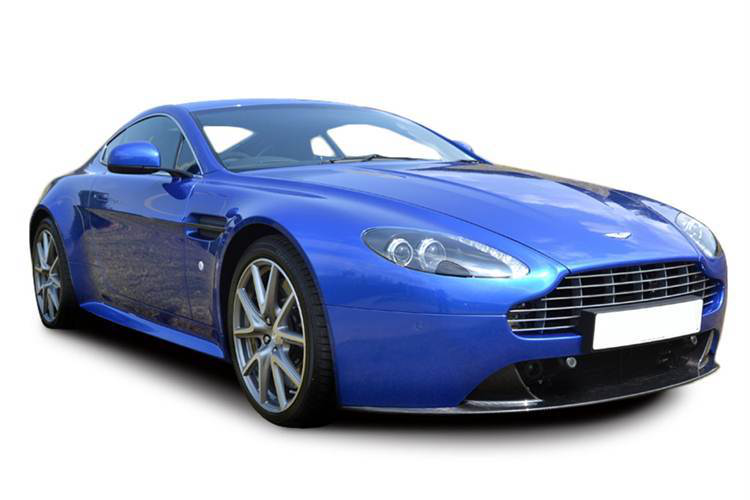


Image class Index :  17
Image class       :  Audi S4 Sedan 2012
Image Size        : (1920, 1358)


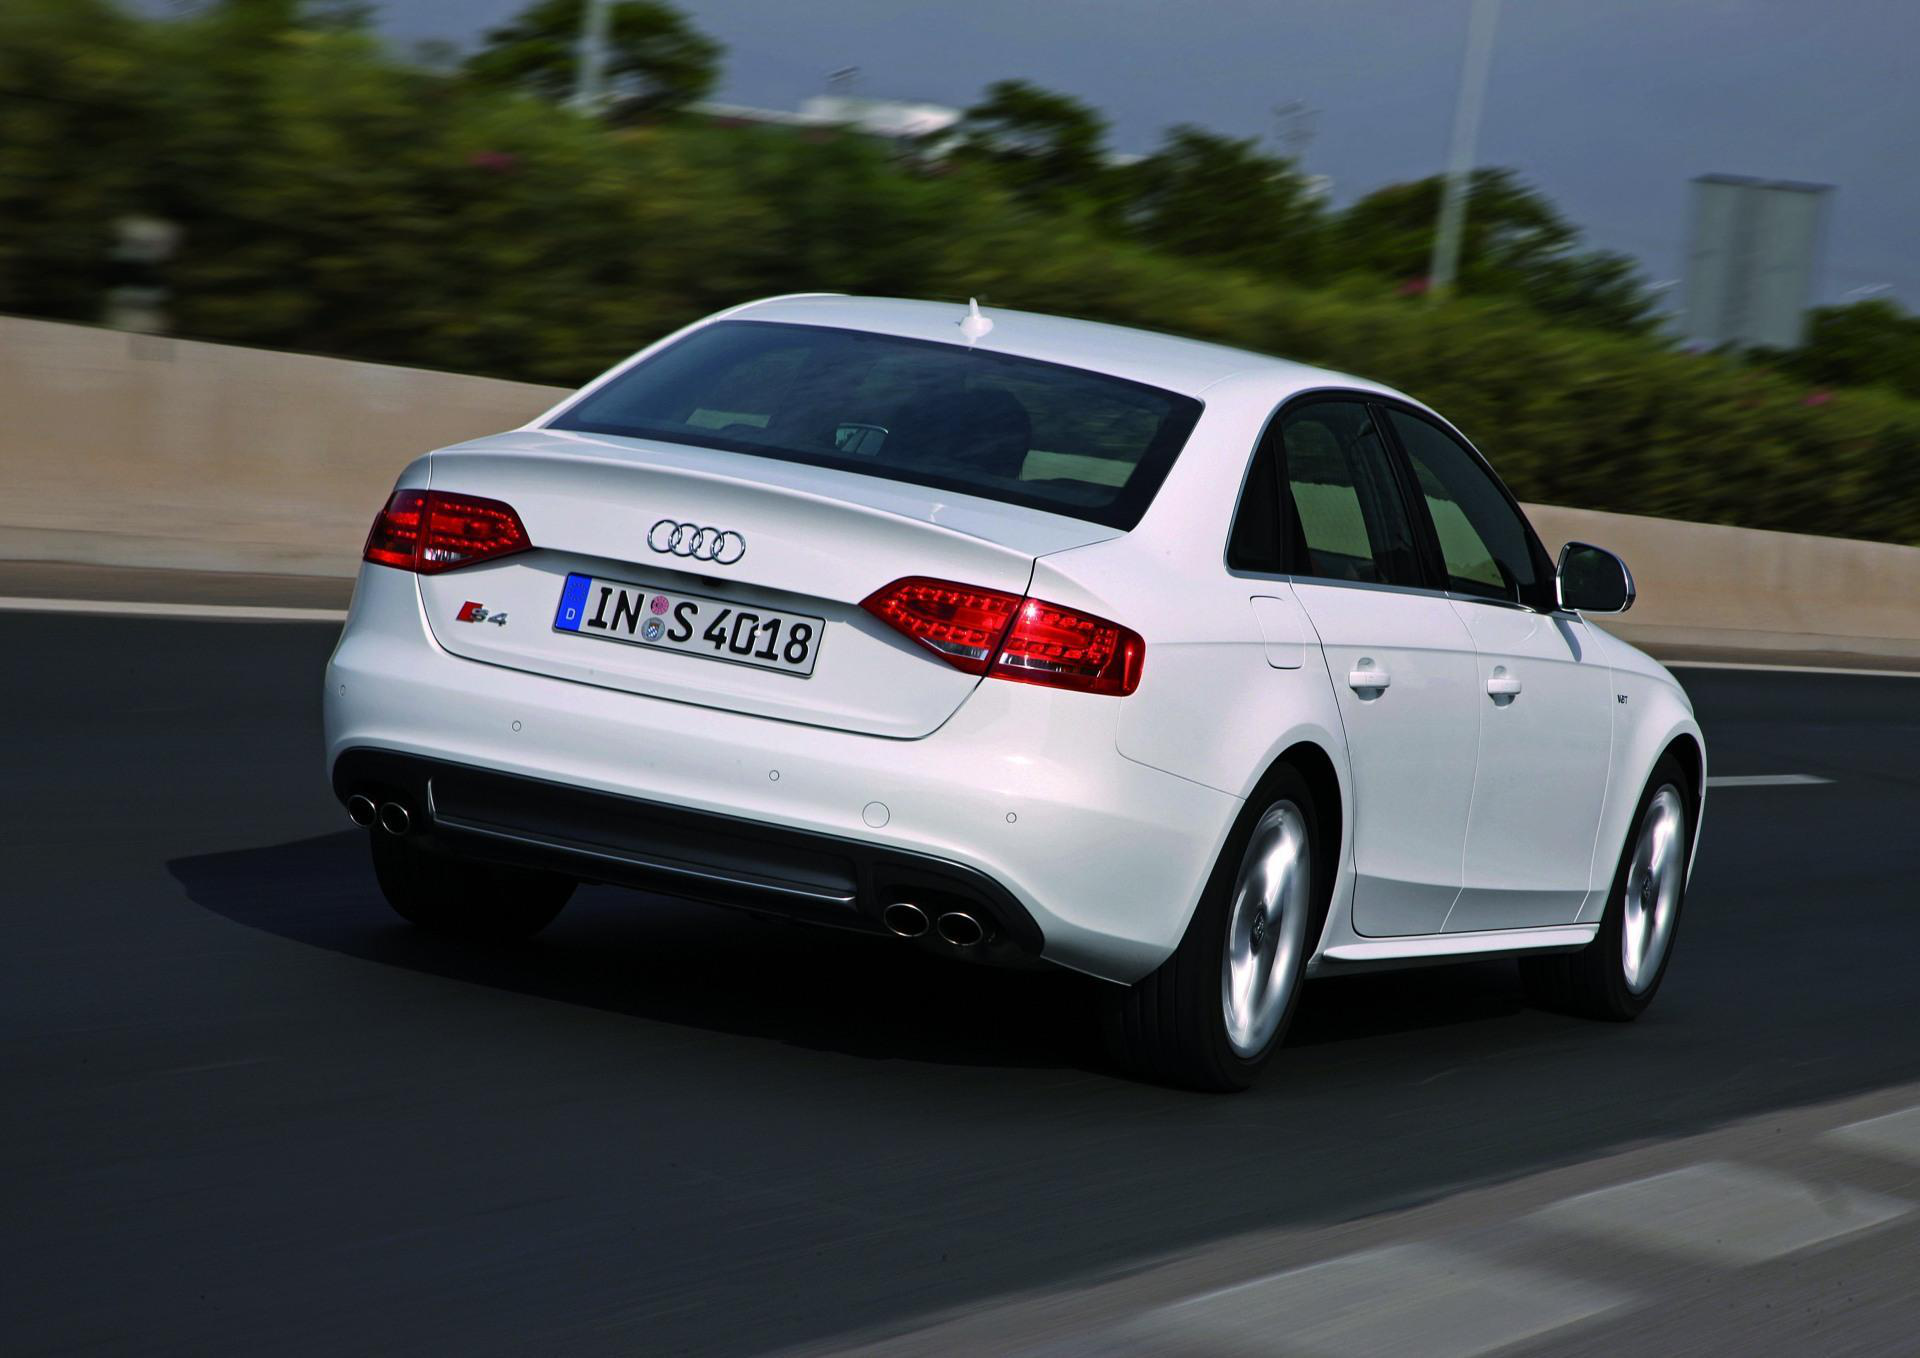

In [40]:
show_image(dataset_images_train, 92);
show_image(dataset_images_train, 190);
show_image(dataset_images_test, 346);
show_image(dataset_images_test, 706);

In [41]:
# Define a Helper method to perform the EDA on class count

In [42]:
def class_count_analysis():
    print('\n\nNo. of classes Available :\n')
    print("\tIn Training Set\t\t: ", len(dataset_images_train.classes))
    print("\tIn Testing\t\t: ", len(dataset_images_test.classes))
    
    print("\n\nSample classes :\n")
    print("\tFrom Training Dataset \t: ", dataset_images_train.classes[0:2])
    print("\tFrom Testing  Dataset \t: ", dataset_images_test.classes[1:3])
    
    print("\n\nClasses Available For : \n")
    if(dataset_images_train.classes == dataset_images_test.classes):
        print("\tTraining & Testing are \t: Equal")
    else:
        print("\tFor Training & Testing are \t: Unequal")

In [43]:
# Define a Helper method to perform the EDA on Image count

In [44]:
def image_count_analysis():
    print("\n\nCount of Images :\n")
    print("\tIn Trainning Set \t:", len(dataset_images_train.imgs))
    print("\tIn Testing Set \t\t:", len(dataset_images_test.imgs))

In [45]:
# Define a Helper method to perform the EDA on Image type

In [46]:
def image_type_analysis():
    print("\n\nImage Extentions Validated :\n")
    print("\tFor Train \t\t:", dataset_images_train.extensions)
    print("\tFor Test  \t\t:", dataset_images_train.extensions)
    
    print("\n\nImages In Training Set With Extention :\n")
    for ex in dataset_images_train.extensions:
        try:
            print("\t"+ex.capitalize()+"\t\t\t:", 
                  len(dataset_images_train.make_dataset(datadir_root, {'train':0}, extensions=ex.lower() )))
        except:
            print("\t"+ex.capitalize()+"\t\t\t:", 0)
            continue
    print("\n\nImages In Testing Set With Extention :\n")
    for ex in dataset_images_test.extensions:
        try:
            print("\t"+ex.capitalize()+"\t\t\t:", 
                  len(dataset_images_test.make_dataset(datadir_root, {'test':0}, extensions=ex.lower() )))
        except:
            print("\t"+ex.capitalize()+"\t\t\t:", 0)
            continue

In [47]:
# Define a Helper method to perform the EDA on Image Chennel

In [48]:
def image_chennel_analysis():
    print("\n\nNo. of Color Channels Available in : \n")
    print("\tTrain \t\t\t: ", set(image_metadata_train.iloc[:, 3].tolist()))
    print("\tTest \t\t\t: ",  set(image_metadata_train.iloc[:, 3].tolist()))

In [49]:
# Define a Helper method to perform the EDA on CSV Data Count

In [50]:
def csv_count():
    print("\n\nNo. of Null/Empty Rows In:\n")
    print("\tAnnotation Train Set\t: ", 
          dataset_annotation_train[dataset_annotation_train.isna().any(axis = 1)].size);
    print("\tAnnotation Test  Set\t: ", 
          dataset_annotation_test[dataset_annotation_test.isna().any(axis = 1)].size);
    print("\tClasses Set \t\t: ", 
          dataset_classes[dataset_classes.isna().any(axis = 1)].size);
    print("\n\nShape of :\n")
    print("\tAnnotation Train Set \t: ",dataset_annotation_train.shape)
    print("\tAnnotation Test  Set \t: ",dataset_annotation_test.shape)
    print("\tClasses Set\t\t: ",dataset_classes.shape)

In [51]:
# Define a Helper method to perform the EDA on Image per class Count

In [52]:
def image_per_class():
    print("\n\nNo. of Images/class in Train Set[sample] : \n\n")
    global image_countperclass_train
    image_countperclass_train = pd.DataFrame(columns=["class", "count"])
    for x in dataset_images_train.class_to_idx:
        try:
            y = len(dataset_images_train.make_dataset(datadir_image_train, {x: 0}, 
                                              extensions=dataset_images_train.extensions))
            temp = {'class' : x, "count": y}
            image_countperclass_train = image_countperclass_train.append(temp, ignore_index=True)
        except:
            continue
    print(image_countperclass_train.head(15).to_markdown())
    print("\n\tMin \t\t\t: ",image_countperclass_train.min()["count"],"for "
          +image_countperclass_train.min()["class"])
    print("\tMax \t\t\t: ",image_countperclass_train.max()["count"],"for "
          +image_countperclass_train.max()["class"])
    print("\tAvg Image Per Class \t: ", image_countperclass_train.mean()['count'])
    
    print("\n\nNo. of Images/class in Train Set[sample] : \n\n")
    global image_countperclass_test
    image_countperclass_test = pd.DataFrame(columns=["class", "count"])
    for x in dataset_images_test.class_to_idx:
        try:
            y = len(dataset_images_test.make_dataset(datadir_image_test, {x: 0}, 
                                              extensions=dataset_images_test.extensions))
            temp = {'class' : x, "count": y}
            image_countperclass_test = image_countperclass_test.append(temp, ignore_index=True)
        except:
            continue
    print(image_countperclass_test.head(15).to_markdown())
    print("\n\tMin \t\t\t: ",image_countperclass_test.min()["count"],"for "
          +image_countperclass_test.min()["class"])
    print("\tMax \t\t\t: ",image_countperclass_test.max()["count"],"for "
          +image_countperclass_test.max()["class"])
    print("\tAvg Image Per Class \t: ", image_countperclass_test.mean()['count'])

In [53]:
# Define a Helper method to Visualize the Image Distribution over the class Using Count Plot

In [54]:
def image_over_class_countplot():
    print('\n\n\nImage Distribution over the Classes in Trainning Set :\n')
    f, ax = plt.subplots(figsize=(plot_width, plot_height))
    plot = sns.countplot(data=dataset_annotation_train, x='class_index')
    plot.set(xlabel=None)
    plot.set(xticklabels=[])
    plot.tick_params(bottom=False)
    plt.title("Image Disctribution over Classes in Train Set")
    plt.show();
    
    print('\n\n\nImage Distribution over the Classes in Testing Set :\n')
    f, ax = plt.subplots(figsize=(plot_width, plot_height))
    plot = sns.countplot(data=dataset_annotation_test, x='class_index')
    plot.set(xlabel=None)
    plot.set(xticklabels=[])
    plot.tick_params(bottom=False)
    plt.title("Image Disctribution over Classes in Test Set")
    plt.show();

In [55]:
# Define a Helper method to Visualize the Image Distribution over the class Using bar Chart

In [56]:
def image_over_class_barplot():
    print('\n\n\nImage Distribution over the Classes in Trainning Set :\n\n')
    f, ax = plt.subplots(figsize=(10, 40))
    sns.set_color_codes("pastel")
    sns.barplot(x='count', y='class', data=image_countperclass_train, label="Train Class Names", 
                color="r",alpha =.3)
    sns.set_color_codes("muted")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    plt.title("Image Disctribution over Classes in Test Set")
    plt.show()
    
    print('\n\n\nImage Distribution over the Classes in Testing Set :\n\n')
    f, ax = plt.subplots(figsize=(plot_width, 40))
    sns.set_color_codes("pastel")
    sns.barplot(x='count', y='class', data=image_countperclass_test, label="Test Class Names", 
                color="r",alpha =.3)
    sns.set_color_codes("muted")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    plt.title("Image Disctribution over Classes in Test Set")
    plt.show()

In [57]:
# Define a Helper method to Visualize the Image Resolution Distribution Using count plot

In [58]:
def image_resolution_countplot():
    print('\n\n\nImage Size Distribution in Training Set :\n\n')
    f, ax = plt.subplots(figsize=(30, 7))
    plot = sns.countplot(data=image_metadata_train, x='resolution')
    plot.set(xlabel=None)
    plot.set(xticklabels=[])
    plot.tick_params(bottom=False)
    plt.title("Image Disctribution over Classes in Test Set")
    plt.show();
    
    print('\n\n\nImage Size Distribution in Testing Set :\n\n')
    f, ax = plt.subplots(figsize=(30, 7))
    plot = sns.countplot(data=image_metadata_test, x='resolution')
    plot.set(xlabel=None)
    plot.set(xticklabels=[])
    plot.tick_params(bottom=False)
    plt.title("Image Disctribution over Classes in Test Set")
    plt.show();

In [59]:
# Define a Helper method to Visualize the Image Dimension Distribution over

In [60]:
def image_size_distribution_scaterplot():
    print("\n\n\nImage Dimention Disctribution in Train Set :\n\n")
    f, ax = plt.subplots(figsize=(plot_width, plot_height))
    plotdata = pd.DataFrame(image_metadata_train.iloc[:,0:2])
    plot = sns.scatterplot(data=plotdata, x='height', y='width')
    plt.title("Image Dimention Disctribution in Train Set")
    plt.show();
    
    print("\n\n\nImage Dimention Disctribution in Test Set :\n\n")
    f, ax = plt.subplots(figsize=(plot_width, plot_height))
    plotdata = pd.DataFrame(image_metadata_test.iloc[:,0:2])
    plot = sns.scatterplot(data=plotdata, x='height', y='width', color='orange')
    plt.title("Image Dimention Disctribution in Test Set")
    plt.show();

In [61]:
# Define a Method to Perform EDA on Image count Distribution over year

In [62]:
def model_per_year_countplot():
    dataset_classes['year'] = dataset_classes['classes'].apply(lambda x: x[-4::1])
    f, ax = plt.subplots(figsize=(plot_width, plot_height))
    plot = sns.countplot(data=dataset_classes, x='year')
    plt.title("Image Dimention Disctribution in Test Set")
    plt.show();

In [63]:
# Define a Method to Perform EDA on Model Distribution over the year

In [64]:
def model_over_year_catplot():
    dataset_classes['company'] = dataset_classes['classes'].str.extract(pat = '(\w+\s)')
    plot = sns.catplot(data=dataset_classes, y='company', kind='count', height=12)
    plt.title("Image Dimention Disctribution in Test Set")
    plt.show();

In [65]:
# Define a Method to Perform EDA on Loaded Data Set

In [66]:
def perform_eda():
    class_count_analysis()
    image_count_analysis()
    image_type_analysis()
    image_chennel_analysis()
    csv_count()
    image_per_class()
    image_over_class_countplot()
    image_over_class_barplot()
    image_resolution_countplot()
    image_size_distribution_scaterplot()
    model_per_year_countplot()
    model_over_year_catplot()



No. of classes Available :

	In Training Set		:  196
	In Testing		:  196


Sample classes :

	From Training Dataset 	:  ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001']
	From Testing  Dataset 	:  ['Acura Integra Type R 2001', 'Acura RL Sedan 2012']


Classes Available For : 

	Training & Testing are 	: Equal


Count of Images :

	In Trainning Set 	: 8144
	In Testing Set 		: 8041


Image Extentions Validated :

	For Train 		: ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
	For Test  		: ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


Images In Training Set With Extention :

	.jpg			: 8144
	.jpeg			: 0
	.png			: 0
	.ppm			: 0
	.bmp			: 0
	.pgm			: 0
	.tif			: 0
	.tiff			: 0
	.webp			: 0


Images In Testing Set With Extention :

	.jpg			: 8041
	.jpeg			: 0
	.png			: 0
	.ppm			: 0
	.bmp			: 0
	.pgm			: 0
	.tif			: 0
	.tiff			: 0
	.webp			: 0


No. of Color Channels Available in : 

	Train 			:  {'RGB'}
	Test 			:  {'RG

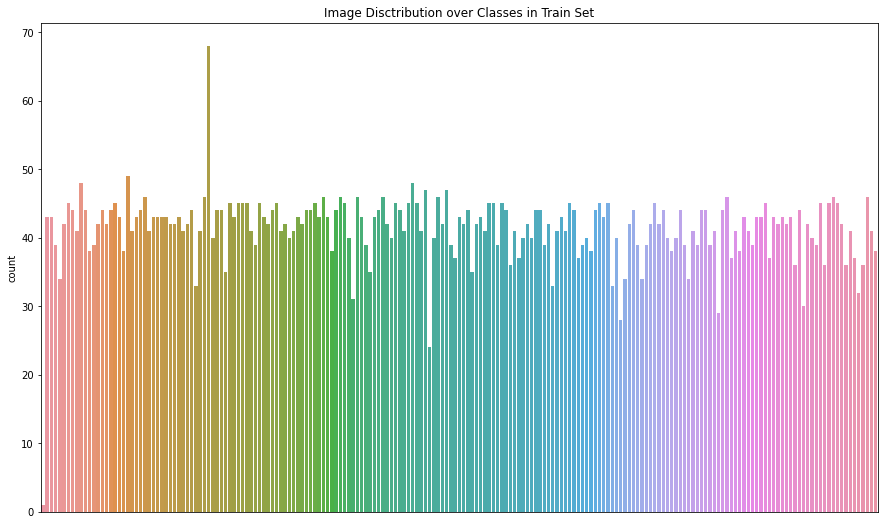




Image Distribution over the Classes in Testing Set :



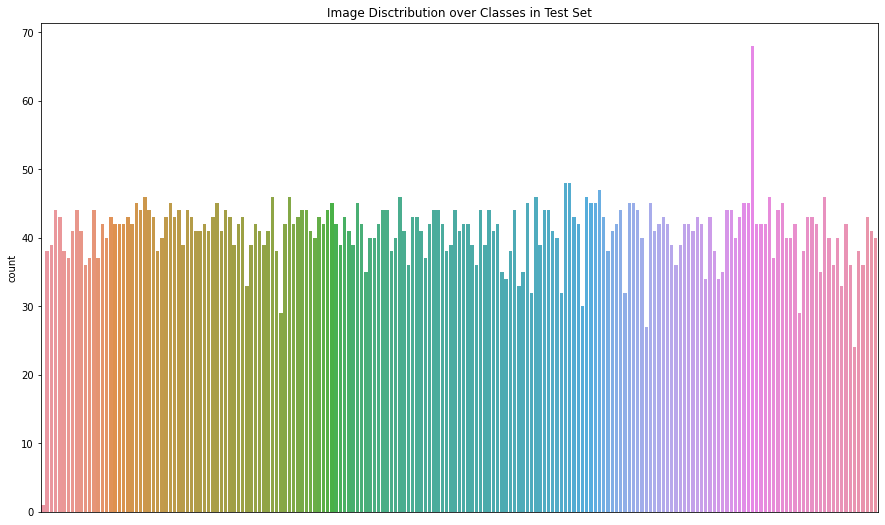




Image Distribution over the Classes in Trainning Set :




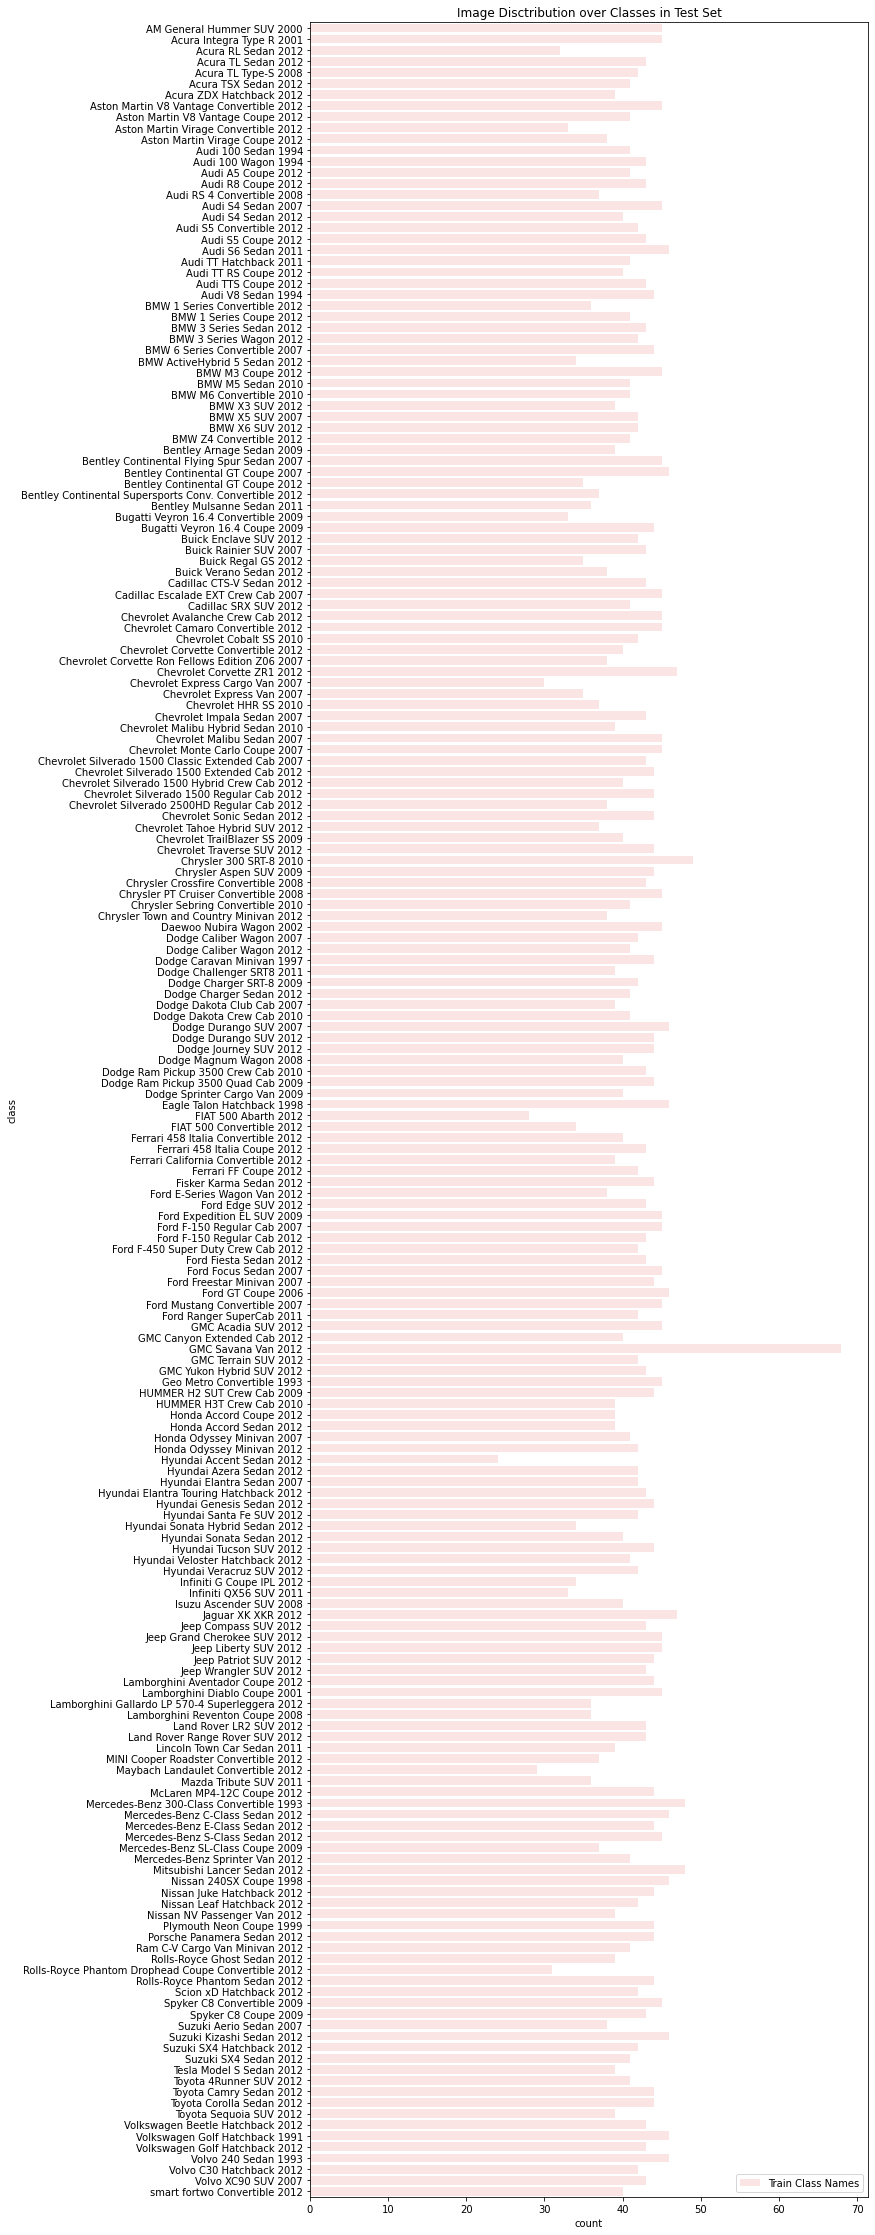




Image Distribution over the Classes in Testing Set :




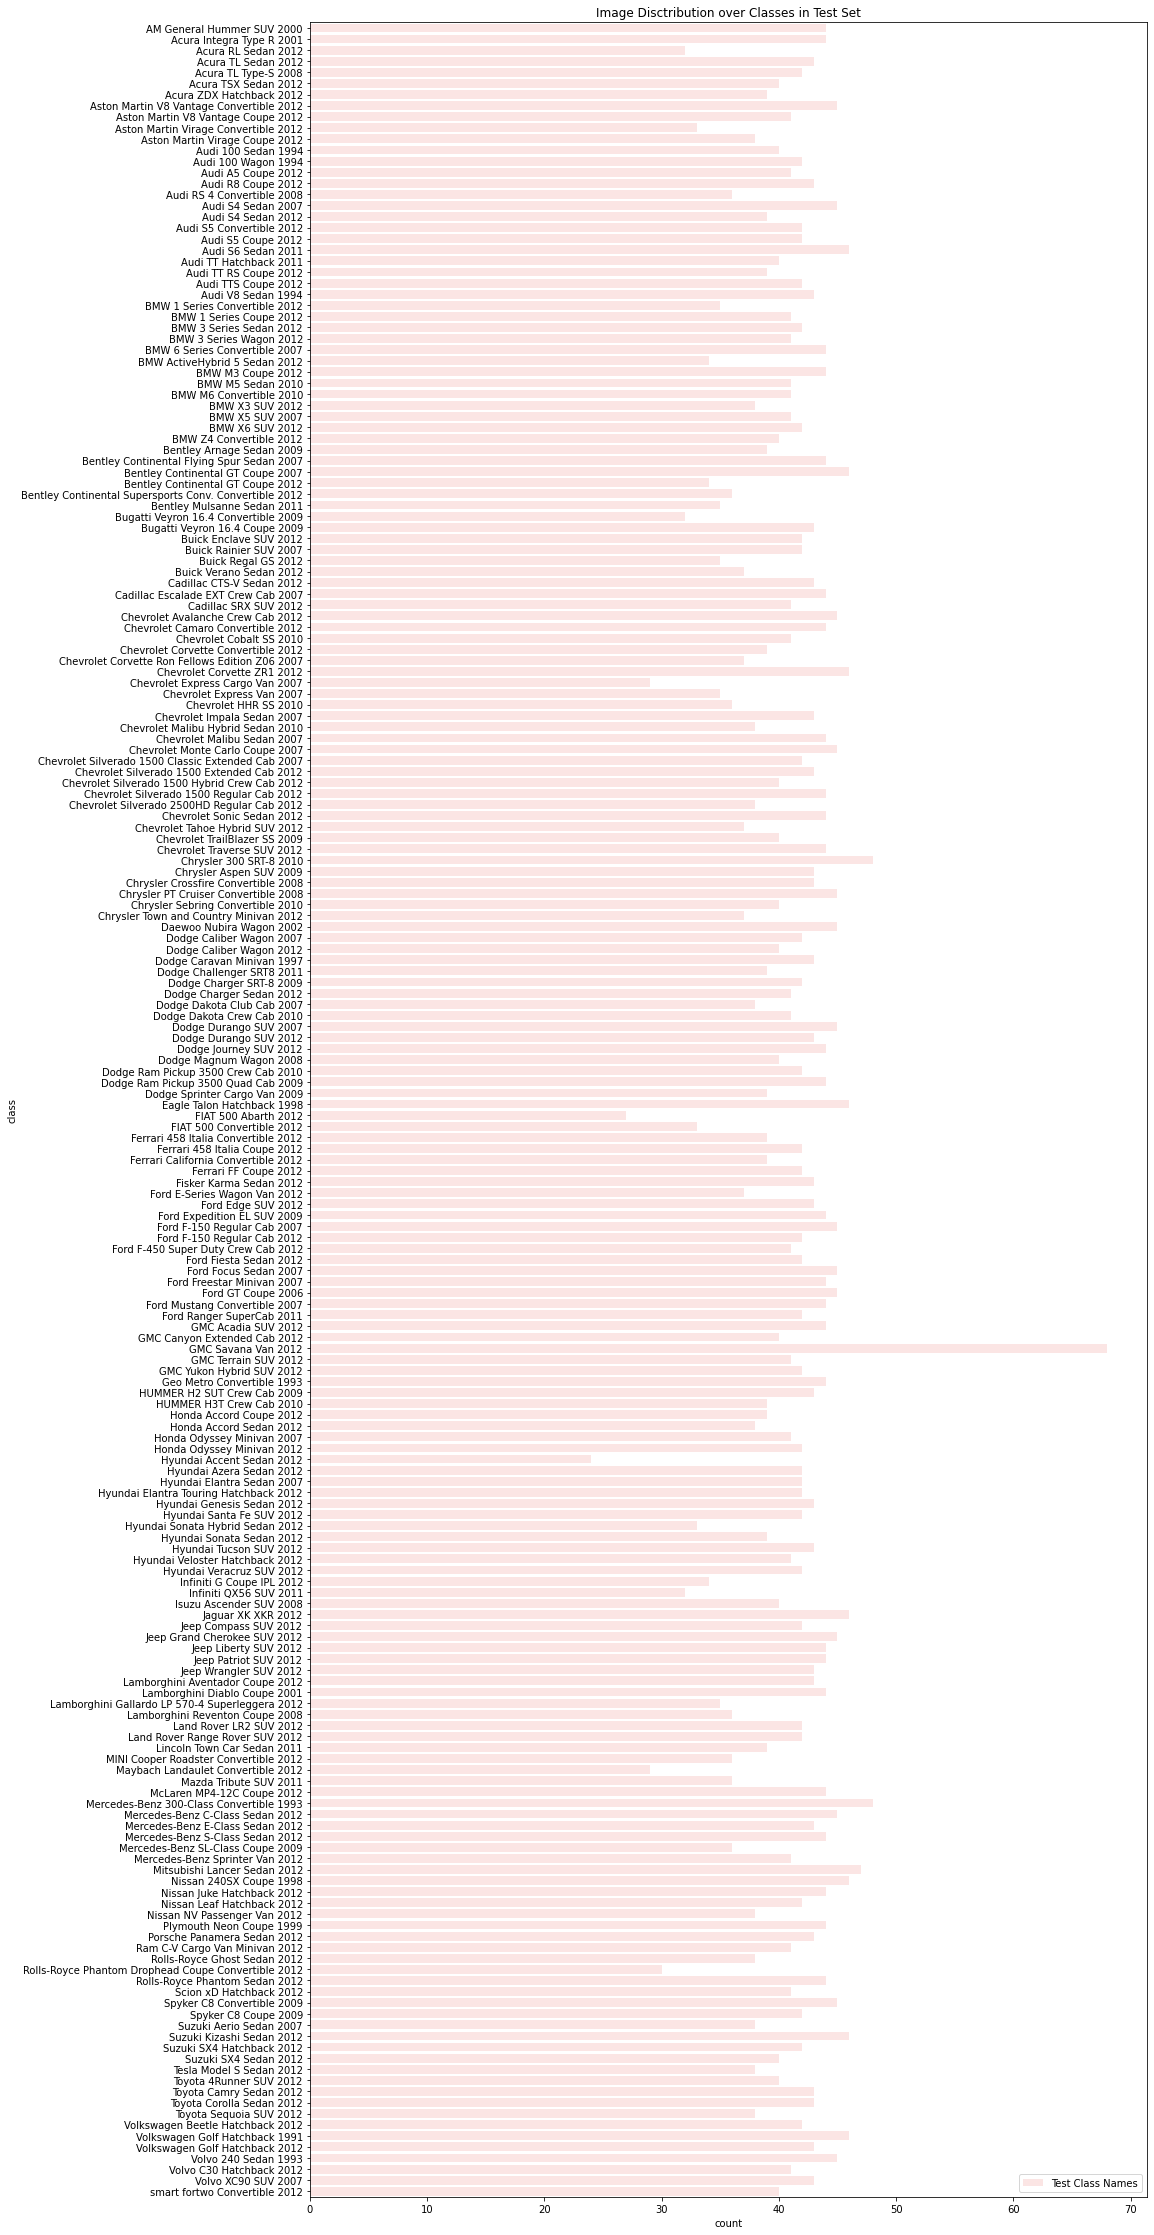




Image Size Distribution in Training Set :




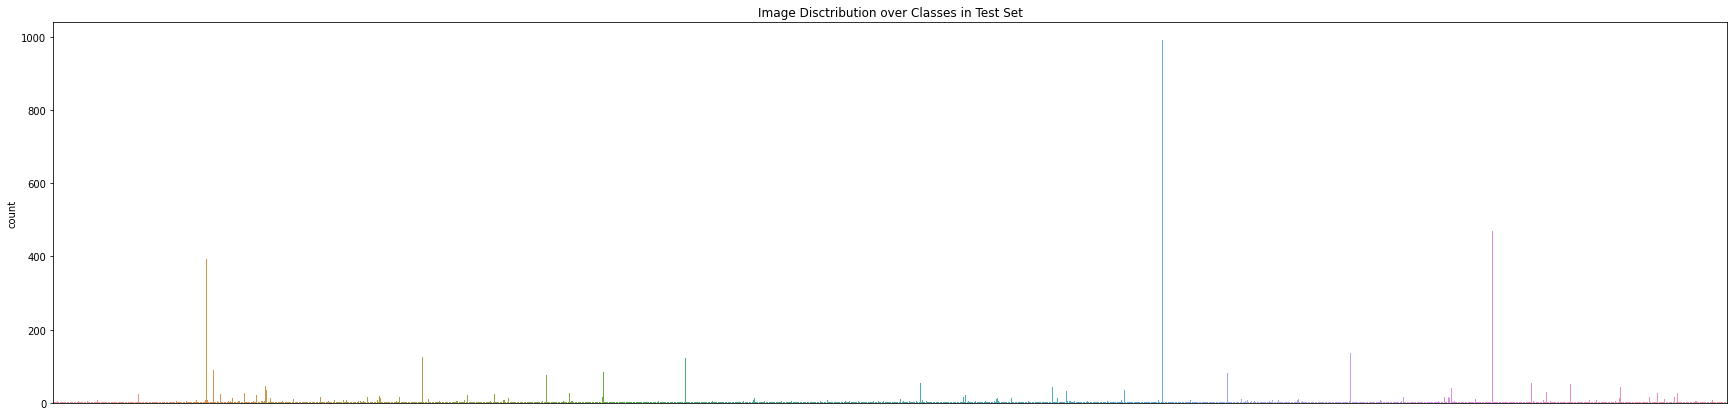




Image Size Distribution in Testing Set :




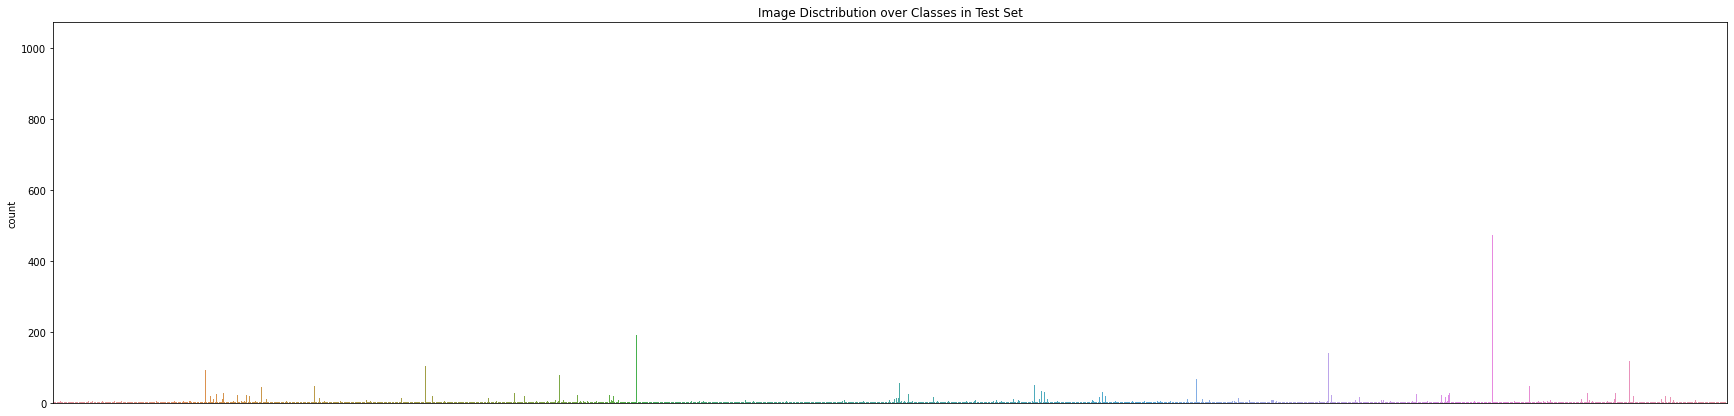




Image Dimention Disctribution in Train Set :




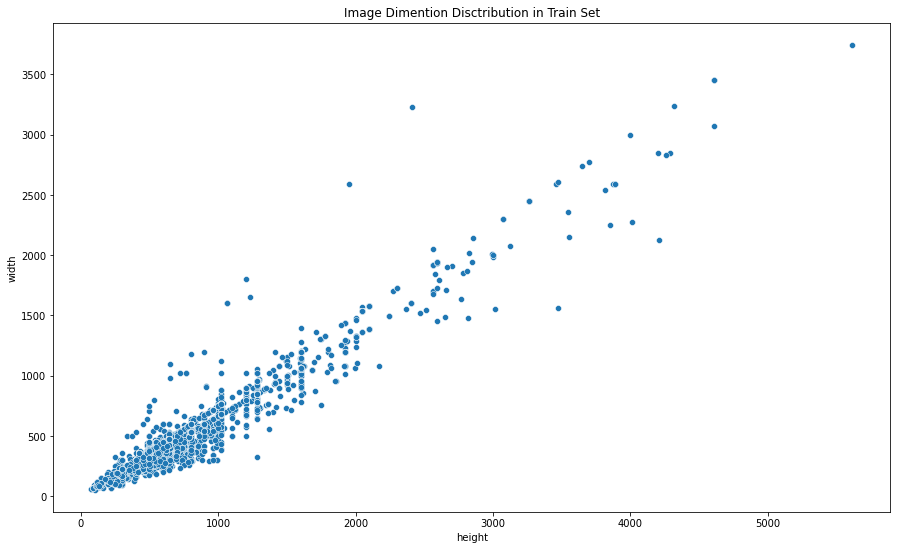




Image Dimention Disctribution in Test Set :




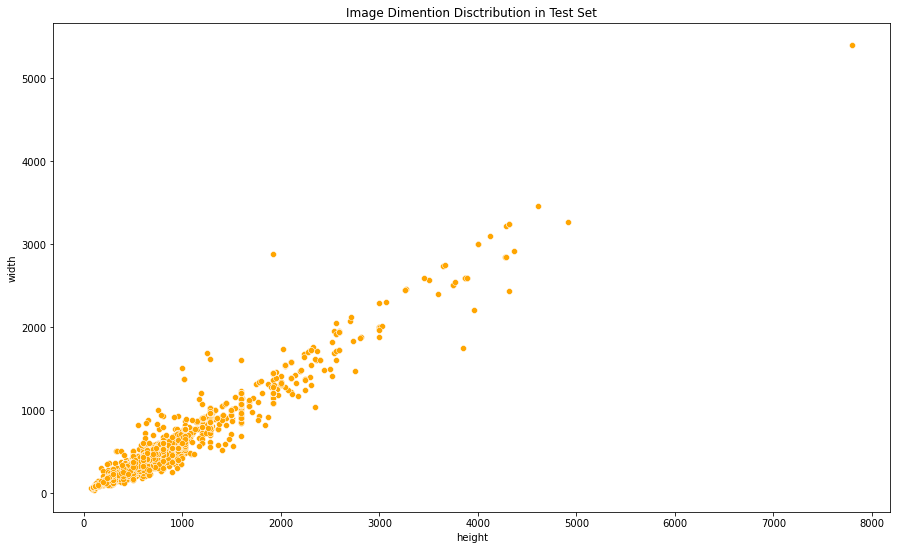

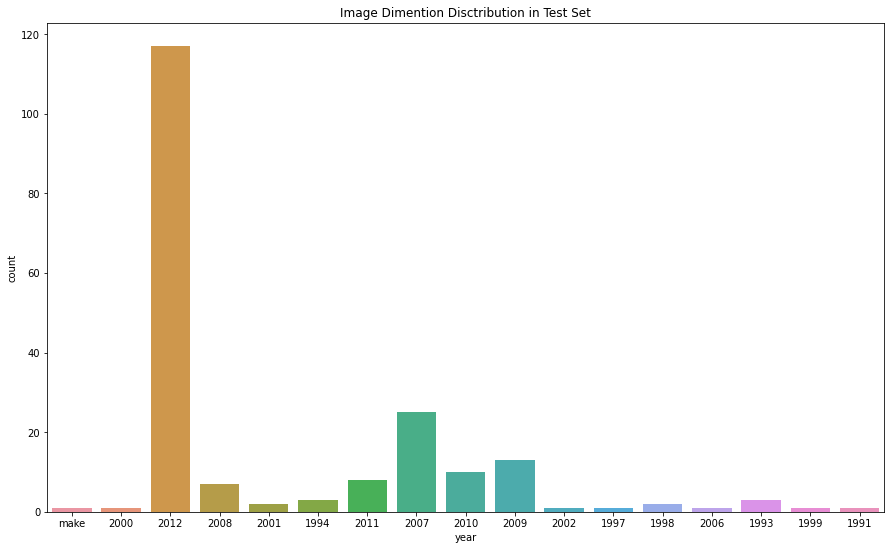

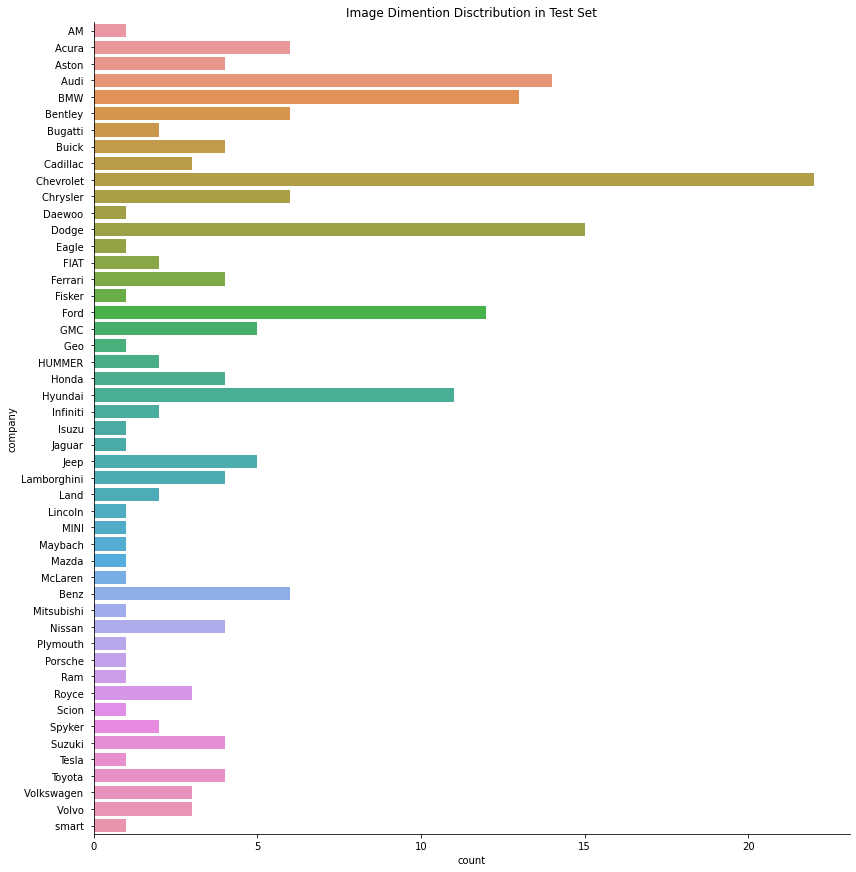

In [67]:
perform_eda()

## EDA & Visualisation Summary : 

An Exploratory Data Analysis have been done on the provided Data Set and as a result we
have found significant analytical outcomes which are mentioned as following :

    ▪ As a Data Set, we have provided with 16,185 images of 196 different cars. These Images are grouped into two sets, Train and Test.
    ▪ Train set contain contains 8,144 and Test set contain 8041 images.
    ▪ In these Train and Test sets all these images are grouped based on the type of the Cars they represent. There is total 196 groups of Cars.
    ▪ Each Train and Test set contains 196 set represented by the Name or Label of the Car, Each of These Set Contains Avg 41 image of Car they Represents
    ▪ The Labels of these Set are given n the Format of “Full Name of Car Year”, e.g.: ‘AM General Hummer SUV 2000’ or ‘Acura RL Sedan 2012’
    ▪ Both Train and Test set contains Same subset for the Car Labels, In Same Order
    ▪ For the Car “AM General Hummer SUV 2000” there are only 24 images are provided which is the least no. of images provided for any other Cars Label
    ▪ For the Car “smart fortwo Convertible 2012” there are 68 instance of car images provided which is the highest no. of images provided for any Cars Label
    ▪ Avg 41 Instance of Images are provided for Each Label of Car
    ▪ For the Model Building and Analysis, we have considered following image extensions :('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'), i.e., any images which are having extension from the mentioned list are considered for the analysis and will be used in our model and any other extension will not be part of the solution.
    ▪ As per the EDA, In the Image data set we have all the images with the extension “jpg”, and for the other extensions we don’t have images 
    ▪ All the Images provided to use is having three “RGB” channels
    ▪ An annotation CSV is provided which contains the details of Bounding Box and Image Name. All the Name of the Images are unique given by the five-digit number
    ▪ In the Annotation CSV we don’t have any row with Empty or Null Values.
    ▪ Two annotation CSV file is provided, one for the Train Set and other for the Test Set, and their no. of rows are equal to the no. of images in their respecting image set i.e.: train annotation CSV contains 8144 rows for each image from the train set.
    ▪ We are provided with the CSV of Car Labels, in which the Name and Order of the Labels are exactly same as it is in the Train or Test Set
    ▪ All the images are having different resolution and size. 
    ▪ Above is the distribution graph of the images
    ▪ The above distribution graph shows that we have Images of all verity of resolutions which is spread evenly across the size i.e.: we have nearly equal no. of images for all the size.
    ▪ The above size distribution graph show that we 80% of images having size 800x800 or less and 50% of the Images are having size range from 450 to 650
    ▪ The model per year distributin graph presents the info that in most of the car model are launched in 2012 and in 1991 very few car models get launched
    ▪ The model over the year distribution shows that Chevrolet is having most number of car models in the market where there are 19 companies which are having least no. of car models., these companies are like AM, Daewoo, Egle, Geo, Isuzu, Jaguar etc.
    ▪ There are total 49 Car Companies

# :- Data Preprocessing

## Step 2: Map training and testing images to its classes.

In [86]:
def map_images_to_classes(image_data_train):
    classes_data = pd.DataFrame(list(dataset_images_train.class_to_idx.items()), columns=['classes', 'class_index'])
    mapped_data = pd.merge(image_data_train, classes_data, on='class_index', how='inner')
    return mapped_data
    

In [87]:
image_data_train = map_images_to_classes(image_data_train)
image_data_test = map_images_to_classes(image_data_test)

In [88]:
image_data_train

image_path class_index  \
0     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
1     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
2     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
3     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
4     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
...                                                 ...         ...   
8139  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8140  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8141  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8142  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8143  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   

      file_name                      classes_x                      classes_y  \
0     00163.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
1     00462.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
2     00522.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
3     00707.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
4     00773.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
...         ...                            ...                            ...   
8139  07537.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8140  07594.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8141  07846.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8142  07895.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8143  08141.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   

                            classes  
0        AM General Hummer SUV 2000  
1        AM General Hummer SUV 2000  
2        AM General Hummer SUV 2000  
3        AM General Hummer SUV 2000  
4        AM General Hummer SUV 2000  
...                             ...  
8139  smart fortwo Convertible 2012  
8140  smart fortwo Convertible 2012  
8141  smart fortwo Convertible 2012  
8142  smart fortwo Convertible 2012  
8143  smart fortwo Convertible 2012  

[8144 rows x 6 columns]

In [89]:
image_data_test

image_path class_index  \
0     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
1     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
2     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
3     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
4     /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...           0   
...                                                 ...         ...   
8036  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8037  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8038  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8039  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   
8040  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...         195   

      file_name                      classes_x                      classes_y  \
0     00076.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
1     00457.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
2     00684.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
3     01117.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
4     01167.jpg     AM General Hummer SUV 2000     AM General Hummer SUV 2000   
...         ...                            ...                            ...   
8036  06615.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8037  06886.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8038  07236.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8039  07467.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   
8040  07592.jpg  smart fortwo Convertible 2012  smart fortwo Convertible 2012   

                            classes  
0        AM General Hummer SUV 2000  
1        AM General Hummer SUV 2000  
2        AM General Hummer SUV 2000  
3        AM General Hummer SUV 2000  
4        AM General Hummer SUV 2000  
...                             ...  
8036  smart fortwo Convertible 2012  
8037  smart fortwo Convertible 2012  
8038  smart fortwo Convertible 2012  
8039  smart fortwo Convertible 2012  
8040  smart fortwo Convertible 2012  

[8041 rows x 6 columns]

## Step 3: Map training and testing images to its annotations.

In [92]:
def map_images_to_annotation(dataset_annotation_set, image_data_set):
    columns = [	'file_name',	'x1',	'y1',	'x2',	'y2',	'class_index']
    dataset_annotation_set = re
    mapped_data = pd.merge(dataset_annotation_set, image_data_set, on=['file_name'], how='inner')
    mapped_data = mapped_data[['x1', 'y1', 'x2', 'y2', 'classes', 'file_name', 'image_path']]
    return mapped_data
    

In [100]:
# dataset_annotation_train = map_images_to_annotation(dataset_annotation_train, image_data_train)
# dataset_annotation_test  = map_images_to_annotation(dataset_annotation_test, image_data_test)

In [94]:
dataset_annotation_train.sample(5)

x1     y1     x2     y2                                     classes  \
294   150  114.0  524.0  433.0                      Buick Enclave SUV 2012   
5418  186   90.0  556.0  280.0                        FIAT 500 Abarth 2012   
324    12   21.0  285.0  142.0                     Honda Accord Coupe 2012   
5541   34   86.0  597.0  280.0  Bentley Continental Flying Spur Sedan 2007   
3103  105   58.0  837.0  370.0                   Cadillac CTS-V Sedan 2012   

      file_name                                         image_path  
294   00295.jpg  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
5418  05419.jpg  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
324   00325.jpg  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
5541  05542.jpg  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
3103  03104.jpg  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...

In [96]:
dataset_annotation_test.sample(5)

x1     y1     x2     y2                              classes  file_name  \
1328  14   55.0  300.0  213.0                  GMC Savana Van 2012  01329.jpg   
4785  19  192.0  492.0  397.0  Ferrari California Convertible 2012  04786.jpg   
3247  45   38.0  985.0  702.0    Mercedes-Benz SL-Class Coupe 2009  03248.jpg   
14    50  103.0  569.0  403.0             Dodge Caliber Wagon 2012  00015.jpg   
53     6   22.0  254.0  174.0          Lincoln Town Car Sedan 2011  00054.jpg   

                                             image_path  
1328  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
4785  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
3247  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
14    /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
53    /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...

## Step 4: Display images with bounding box

In [97]:
def display_boundingbox(dataset_annotation_set, index):
    imgx = read_image(dataset_annotation_set['image_path'][index])
    bounding_vector = torch.tensor(dataset_annotation_set.iloc[index, [0, 1, 2, 3]].tolist(), dtype=torch.int)
    bounding_vector = bounding_vector.unsqueeze(0)
    imgx=draw_bounding_boxes(imgx, bounding_vector, width=3, colors=(255,255,0)) 
    imgx = transforms.ToPILImage()(imgx)
    display(imgx)

In [99]:
# display_boundingbox(dataset_annotation_train, 279)
# display_boundingbox(dataset_annotation_test, 165)
# display_boundingbox(dataset_annotation_train, 793)
# display_boundingbox(dataset_annotation_test, 692)

# Faster-RCNN

##DataPreprocessing

In [105]:
dataset_annotation_train.head()

x1     y1      x2      y2                              classes  file_name  \
0   39  116.0   569.0   375.0                  Audi TTS Coupe 2012  00001.jpg   
1   36  116.0   868.0   587.0                  Acura TL Sedan 2012  00002.jpg   
2   85  109.0   601.0   381.0           Dodge Dakota Club Cab 2007  00003.jpg   
3  621  393.0  1484.0  1096.0     Hyundai Sonata Hybrid Sedan 2012  00004.jpg   
4   14   36.0   133.0    99.0  Ford F-450 Super Duty Crew Cab 2012  00005.jpg   

                                          image_path  
0  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
1  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
2  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
3  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
4  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...

In [106]:
train = dataset_annotation_train.filter(['image_path', 'x1', 'y1', 'x2', 'y2', 'classes'],axis=1)

In [107]:
dataset_annotation_test.head()

x1     y1     x2     y2                              classes  file_name  \
0   30   52.0  246.0  147.0              Suzuki Aerio Sedan 2007  00001.jpg   
1  100   19.0  576.0  203.0  Ferrari 458 Italia Convertible 2012  00002.jpg   
2   51  105.0  968.0  659.0                Jeep Patriot SUV 2012  00003.jpg   
3   67   84.0  581.0  407.0              Toyota Camry Sedan 2012  00004.jpg   
4  140  151.0  593.0  339.0             Tesla Model S Sedan 2012  00005.jpg   

                                          image_path  
0  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
1  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
2  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
3  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...  
4  /content/drive/MyDrive/AIML/CP1/Traffic_1/whee...

In [108]:
test = dataset_annotation_train.filter(['image_path', 'x1', 'y1', 'x2', 'y2', 'classes'],axis=1)

In [113]:
train_df = train[int(train.shape[0]*0.0001):]
test_df = test[int(test.shape[0]*0.96):]

In [114]:
print(len(train_df))
print(len(test_df))

8144
82


In [120]:
with open("/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/anno_train.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread(row['image_path'])
      height, width = img.shape[:2]
      x1 = int(row['x1'])
      x2 = int(row['x2'])
      y1 = int(row['y1'])
      y2 = int(row['y2'])

      fileName = row['image_path']
      className = row['classes']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [121]:
with open("/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/anno_test.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread(row['image_path'])
      height, width = img.shape[:2]
      x1 = int(row['x1'])
      x2 = int(row['x2'])
      y1 = int(row['y1'])
      y2 = int(row['y2'])

      fileName = row['image_path']
      className = row['classes']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

##Config

In [122]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

##Get data

In [123]:
def get_data(input_path):
  """Parse the data from annotation file
  
  Args:
    input_path: annotation file path
      
  Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
  found_bg = False
  all_imgs = {}

  classes_count = {}

  class_mapping = {}

  visualise = True

  i = 1
	
  with open(input_path,'r') as f:
    print('Parsing annotation files')
    
    for line in f:
      
      # Print process
      sys.stdout.write('\r'+'idx=' + str(i))
      i += 1
      line_split = line.strip().split(',')
			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2
      (filename,x1,y1,x2,y2,class_name) = line_split
      
      if class_name not in classes_count:
        classes_count[class_name] = 1
      else:
        classes_count[class_name] += 1

      if class_name not in class_mapping:
        if class_name == 'bg' and found_bg == False:
          print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
          found_bg = True
        class_mapping[class_name] = len(class_mapping)

      if filename not in all_imgs:
        all_imgs[filename] = {}
				
        img = cv2.imread(filename)
        (rows,cols) = img.shape[:2]
        all_imgs[filename]['filepath'] = filename
        all_imgs[filename]['width'] = cols
        all_imgs[filename]['height'] = rows
        all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

      all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


    all_data = []
    for key in all_imgs:
      all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
    if found_bg:
      if class_mapping['bg'] != len(class_mapping) - 1:
        key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
        val_to_switch = class_mapping['bg']
        class_mapping['bg'] = len(class_mapping) - 1
        class_mapping[key_to_switch] = val_to_switch
		
    return all_data, classes_count, class_mapping

##Model

###ROI

In [124]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

###VGG16

In [125]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

###RPN

In [126]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

###Classifier

In [127]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

###IOU

In [128]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

###RPN calc

In [129]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

###Augment

In [130]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

###Anchor box

In [131]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

###Loss

In [132]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [133]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):
        
        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
       
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [134]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [135]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

##Train

In [137]:
BASE_PATH = '/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data'

num_rois = 4 # Number of RoIs to process at once.
train_path = os.path.join(BASE_PATH, 'anno_train.txt')
# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(BASE_PATH, 'model/model_frcnn_vgg.hdf5')

record_path = os.path.join(BASE_PATH, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(BASE_PATH, 'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(BASE_PATH, 'model_vgg_config.pickle')

In [138]:
# Create the config
C = Config()

C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [139]:
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=8144
Spend 2.63 mins to load the data


In [140]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'usask_1': 5807,'arvalis_1': 45716,'inrae_1': 3701,'ethz_1': 51489,'arvalis_3': 16665,'rres_1': 9635,'bg':0}
#    class_mapping: {'usask_1': 0,'arvalis_1': 1,'inrae_1': 2,'ethz_1': 3,'arvalis_3': 4,'rres_1': 5,'bg': 6}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Training images per class:
{'AM General Hummer SUV 2000': 45,
 'Acura Integra Type R 2001': 45,
 'Acura RL Sedan 2012': 32,
 'Acura TL Sedan 2012': 43,
 'Acura TL Type-S 2008': 42,
 'Acura TSX Sedan 2012': 41,
 'Acura ZDX Hatchback 2012': 39,
 'Aston Martin V8 Vantage Convertible 2012': 45,
 'Aston Martin V8 Vantage Coupe 2012': 41,
 'Aston Martin Virage Convertible 2012': 33,
 'Aston Martin Virage Coupe 2012': 38,
 'Audi 100 Sedan 1994': 41,
 'Audi 100 Wagon 1994': 43,
 'Audi A5 Coupe 2012': 41,
 'Audi R8 Coupe 2012': 43,
 'Audi RS 4 Convertible 2008': 37,
 'Audi S4 Sedan 2007': 45,
 'Audi S4 Sedan 2012': 40,
 'Audi S5 Convertible 2012': 42,
 'Audi S5 Coupe 2012': 43,
 'Audi S6 Sedan 2011': 46,
 'Audi TT Hatchback 2011': 41,
 'Audi TT RS Coupe 2012': 40,
 'Audi TTS Coupe 2012': 43,
 'Audi V8 Sedan 1994': 44,
 'BMW 1 Series Convertible 2012': 36,
 'BMW 1 Series Coupe 2012': 41,
 'BMW 3 Series Sedan 2012': 43,
 'BMW 3 Series Wagon 2012': 42,
 'BMW 6 Series Convertible 2007': 44,
 'BMW A

In [141]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 8144


In [142]:
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

In [143]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=189 width=300
Resized image:  height=300 width=476 C.im_size=300
Feature map size: height=18 width=29 C.rpn_stride=16
(1, 300, 476, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 29, 18)
Shape of y_rpn_regr (1, 18, 29, 72)
{'filepath': '/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/00673.jpg', 'width': 300, 'height': 189, 'bboxes': [{'class': 'Dodge Ram Pickup 3500 Crew Cab 2010', 'x1': 41, 'x2': 275, 'y1': 1, 'y2': 189}]}
Number of positive anchors for this image: 1
(array([8, 8, 9]), array([12, 12, 19]), array([ 6, 15,  1]))
(array([8, 8, 8, 8]), array([12, 12, 12, 12]), array([24, 25, 26, 27]))
y_rpn_cls for possible pos anchor: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
y_rpn_regr for positive anchor: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

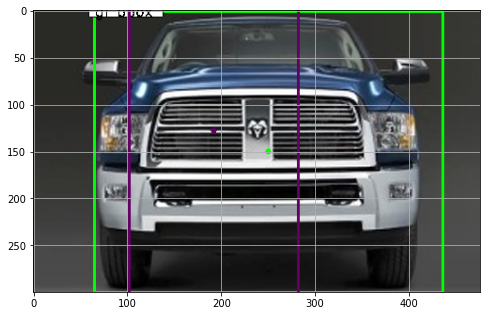

In [144]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

In [145]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [146]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9
rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except:
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

This is the first time of your training
loading weights from /content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5


In [147]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [148]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 99
num_epochs = 5   #Just of sharing the karnel running with 2 epoch , you try with min 20 epochs
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [149]:
print(len(record_df))

0


In [150]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
#                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

Epoch 1/5
66/99 [===================>..........] - ETA: 8:04 - rpn_cls: 6.2801 - rpn_regr: 0.1435 - final_cls: 4.1157 - final_regr: 0.4907Exception: in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-133-91330da15d39>", line 54, in class_loss_regr_fixed_num  *
        x = y_true[:, :, 4*num_classes:] - y_pred

    TypeError: Input 'y' of 'Sub' Op has type float32 that does not match type int64 of argument 'x'.

71/99 [====================>.........] - ETA: 6:56 - rpn_cls: 6.1671 - rpn_regr: 0.1429 - final_cls: 4.0889 - final_regr: 0.4917Exception: in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-133-91330da15d39>", line 54, in class_loss_regr_fixed_num  *
        x = y_true[:, :, 4*num_classes:] - y_pred


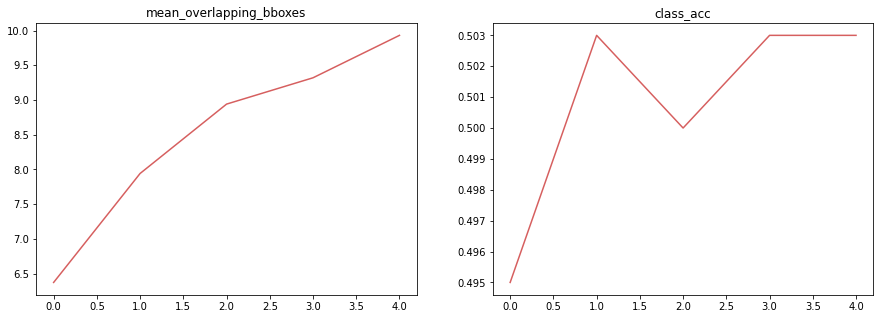

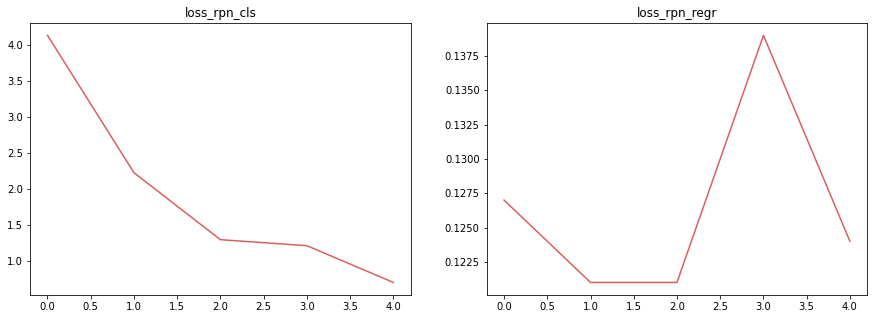

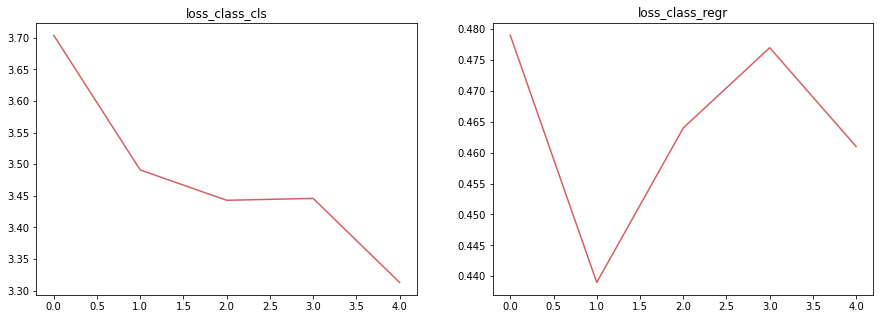

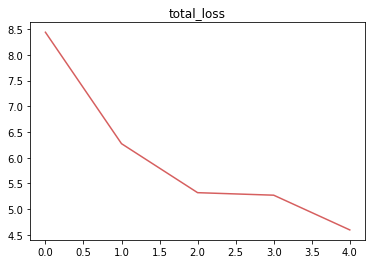

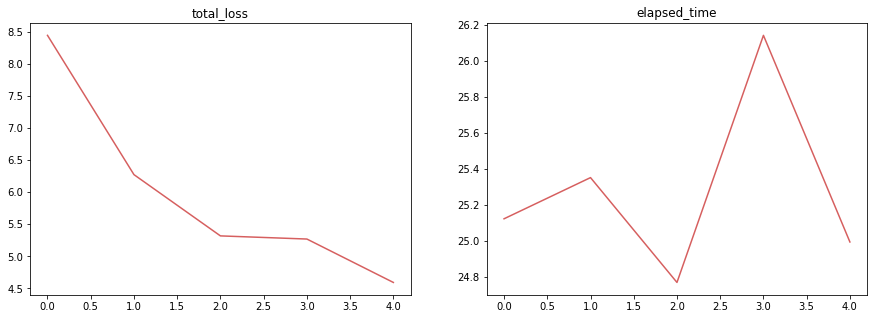

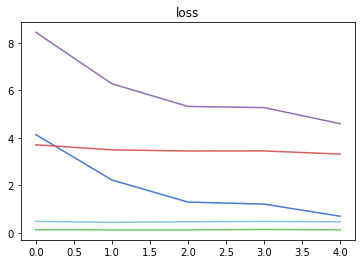

In [151]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')
plt.show()

plt.title('loss')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'b')
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'g')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'c')
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'm')
plt.show()


##Test

In [152]:
test_path = os.path.join(BASE_PATH, 'anno_test.txt') # Test data (annotation file)

test_base_path = os.path.join(BASE_PATH,'test') # Directory to save the test images

config_output_filename = os.path.join(BASE_PATH, 'model_vgg_config.pickle')

In [153]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

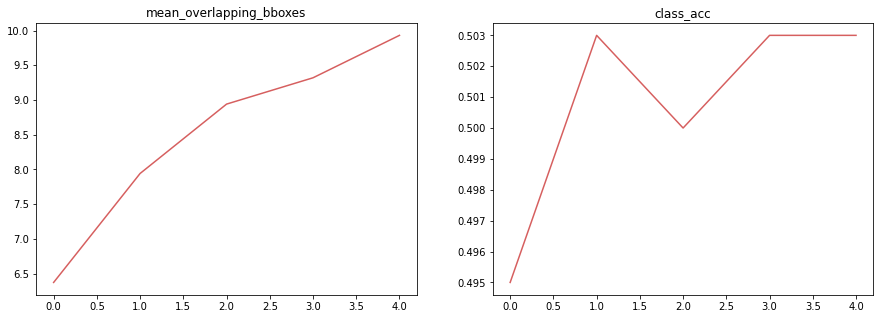

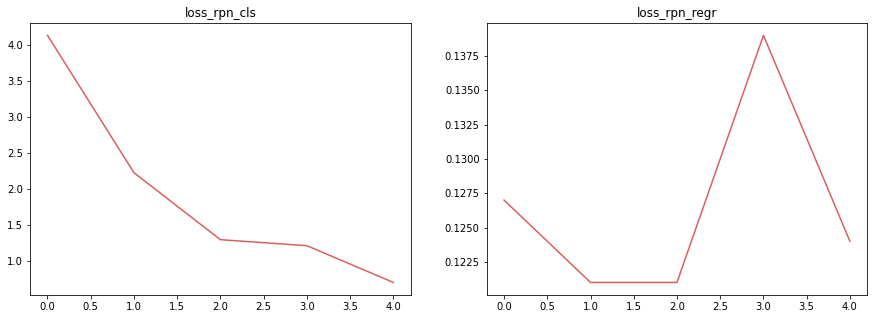

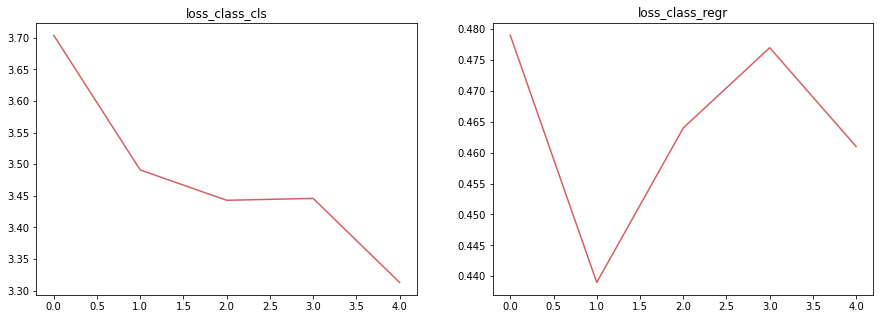

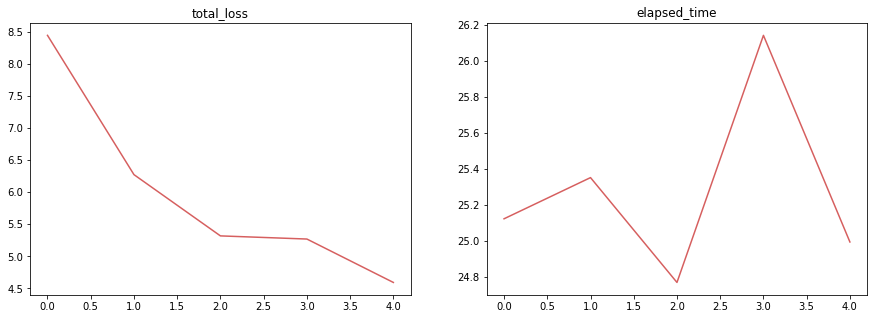

In [156]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

In [157]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [158]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from /content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/model/model_frcnn_vgg.hdf5


In [159]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Audi TTS Coupe 2012', 1: 'Acura TL Sedan 2012', 2: 'Dodge Dakota Club Cab 2007', 3: 'Hyundai Sonata Hybrid Sedan 2012', 4: 'Ford F-450 Super Duty Crew Cab 2012', 5: 'Geo Metro Convertible 1993', 6: 'Dodge Journey SUV 2012', 7: 'Dodge Charger Sedan 2012', 8: 'Mitsubishi Lancer Sedan 2012', 9: 'Chevrolet Traverse SUV 2012', 10: 'Buick Verano Sedan 2012', 11: 'Toyota Sequoia SUV 2012', 12: 'Hyundai Elantra Sedan 2007', 13: 'Dodge Caravan Minivan 1997', 14: 'Volvo C30 Hatchback 2012', 15: 'Plymouth Neon Coupe 1999', 16: 'Chevrolet Malibu Sedan 2007', 17: 'Volkswagen Beetle Hatchback 2012', 18: 'Chevrolet Corvette Ron Fellows Edition Z06 2007', 19: 'Chrysler 300 SRT-8 2010', 20: 'BMW M6 Convertible 2010', 21: 'GMC Yukon Hybrid SUV 2012', 22: 'Nissan Juke Hatchback 2012', 23: 'Volvo 240 Sedan 1993', 24: 'Suzuki SX4 Sedan 2012', 25: 'Dodge Ram Pickup 3500 Crew Cab 2010', 26: 'Spyker C8 Coupe 2009', 27: 'Land Rover Range Rover SUV 2012', 28: 'Hyundai Elantra Touring Hatchback 2012', 29: '

In [164]:
test_imgs = os.listdir('/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000')
testimg_base_path='/content/drive/MyDrive/AIML/CP1/Traffic_1/wheel-vigiler/data-warehouse/car_data/test/AM General Hummer SUV 2000'
imgs_path = ['00457.jpg']

all_imgs = []

classes = {}

00457.jpg
Elapsed time = 23.995301961898804
[]


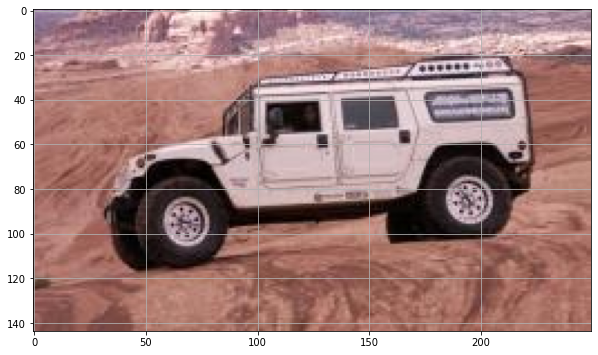

In [165]:
imgs_path# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(testimg_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

In [166]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [167]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [168]:
test_imgs, _, _ = get_data(test_path)

Parsing annotation files
idx=82

In [169]:
T = {}
P = {}
mAPs = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/82
Elapsed time = 18.801379442214966
GMC Acadia SUV 2012 AP: 1.0
mAP = 1.0
1/82
Elapsed time = 14.967246532440186
GMC Acadia SUV 2012 AP: 1.0
Hyundai Tucson SUV 2012 AP: 1.0
mAP = 1.0
2/82
Elapsed time = 15.272008895874023
GMC Acadia SUV 2012 AP: 1.0
Hyundai Tucson SUV 2012 AP: 1.0
Jeep Grand Cherokee SUV 2012 AP: 1.0
mAP = 1.0
3/82
Elapsed time = 18.722266912460327
GMC Acadia SUV 2012 AP: 1.0
Hyundai Tucson SUV 2012 AP: 1.0
Jeep Grand Cherokee SUV 2012 AP: 1.0
Ford Focus Sedan 2007 AP: 1.0
mAP = 1.0
4/82
Elapsed time = 16.602801084518433
GMC Acadia SUV 2012 AP: 1.0
Hyundai Tucson SUV 2012 AP: 1.0
Jeep Grand Cherokee SUV 2012 AP: 1.0
Ford Focus Sedan 2007 AP: 1.0
Lamborghini Reventon Coupe 2008 AP: 1.0
mAP = 1.0
5/82
Elapsed time = 16.81300449371338
GMC Acadia SUV 2012 AP: 1.0
Hyundai Tucson SUV 2012 AP: 1.0
Jeep Grand Cherokee SUV 2012 AP: 1.0
Ford Focus Sedan 2007 AP: 1.0
Lamborghini Reventon Coupe 2008 AP: 1.0
BMW X3 SUV 2012 AP: 1.0
mAP = 1.0
6/82
Elapsed time = 16.67390513420105